In [61]:
# dataset @ https://finance.yahoo.com/quote/INTC/history?period1=322099200&period2=1673913600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [62]:
# Forecasting Intel stock with LSTM neural networks
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Importing csv file with historical stock data
df = pd.read_csv('INTC.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.325521,0.330729,0.325521,0.325521,0.188224,10924800
1,1980-03-18,0.325521,0.328125,0.322917,0.322917,0.186718,17068800
2,1980-03-19,0.330729,0.335938,0.330729,0.330729,0.191235,18508800
3,1980-03-20,0.330729,0.334635,0.329427,0.329427,0.190482,11174400
4,1980-03-21,0.322917,0.322917,0.317708,0.317708,0.183706,12172800
...,...,...,...,...,...,...,...
10795,2023-01-09,28.840000,29.870001,28.840000,29.309999,29.309999,37493200
10796,2023-01-10,29.240000,29.510000,28.920000,29.440001,29.440001,23008100
10797,2023-01-11,29.680000,29.879999,29.000000,29.850000,29.850000,30375400
10798,2023-01-12,29.980000,30.379999,29.469999,30.290001,30.290001,28963900


In [63]:
# Selecting the data and close column
df = df[['Date', 'Close']]
df

,Date,Close
0,1980-03-17,0.325521
1,1980-03-18,0.322917
2,1980-03-19,0.330729
3,1980-03-20,0.329427
4,1980-03-21,0.317708
...,...,...
10795,2023-01-09,29.309999
10796,2023-01-10,29.440001
10797,2023-01-11,29.850000
10798,2023-01-12,30.290001


In [64]:
# A function to convert a string into a date using datetime
def str_to_datetime(s):
  split = s.split('-')
  year,month,day = int(split[0]),int(split[1]),int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [65]:
# Apply the function to all the strings in the date column
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-65-01b1ad50ac68>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0       1980-03-17
1       1980-03-18
2       1980-03-19
3       1980-03-20
4       1980-03-21
           ...    
10795   2023-01-09
10796   2023-01-10
10797   2023-01-11
10798   2023-01-12
10799   2023-01-13
Name: Date, Length: 10800, dtype: datetime64[ns]

In [66]:
# Making the date column the index
df.index = df.pop('Date')
df

,Close
Date,
1980-03-17,0.325521
1980-03-18,0.322917
1980-03-19,0.330729
1980-03-20,0.329427
1980-03-21,0.317708
...,...
2023-01-09,29.309999
2023-01-10,29.440001
2023-01-11,29.850000


Text(0.5, 1.0, 'All-time INTC Stock Closing Prices')

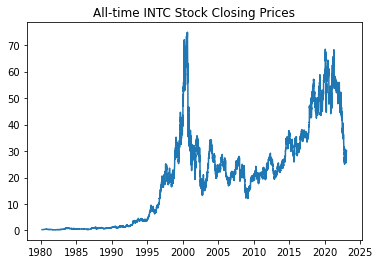

In [67]:
# Plotting the raw data of the date vs. closing price
plt.plot(df.index, df['Close'])
plt.title('All-time INTC Stock Closing Prices')

In [68]:
# Function to convert dataframe into a windowed dataframe to support a
# supervised learning problem (since we are using LSTM model)
# Function returns a dataframe with target date column,target-3,target-2,
# target-1 and target. Target corresponds to closing price of target date. 
# Middle three columns correspond to the 3 closing prices leading up to the 
# target date. 
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df
# Converted data into a supervised learning model by selecting an output date, 
# output value, and the corresponding input for the row. 
windowed_df = df_to_windowed_df(df, 
                                '1980-03-20	', 
                                '2023-01-13', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,1980-03-20,0.325521,0.322917,0.330729,0.329427
1,1980-03-21,0.322917,0.330729,0.329427,0.317708
2,1980-03-24,0.330729,0.329427,0.317708,0.311198
3,1980-03-25,0.329427,0.317708,0.311198,0.312500
4,1980-03-26,0.317708,0.311198,0.312500,0.309896
...,...,...,...,...,...
10792,2023-01-09,27.680000,27.559999,28.730000,29.309999
10793,2023-01-10,27.559999,28.730000,29.309999,29.440001
10794,2023-01-11,28.730000,29.309999,29.440001,29.850000
10795,2023-01-12,29.309999,29.440001,29.850000,30.290001


In [69]:
# Converting windowed dataframe to numpy arrays to be fed into a tensorflow model
# Takes a windowed datafram and outputs a list of dates, a 3 dimensional tensor and a output vector
def windowed_df_to_date_X_y(windowed_dataframe):
  #Convert the whole df into a numpy array
  df_as_np = windowed_dataframe.to_numpy()

  # Select date from all rows in first column
  dates = df_as_np[:, 0]

  # Getting the input matrix by selecting all rows from the middle 3 rows
  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1)) # Last input is one since we are doing univariate forecasting

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((10797,), (10797, 3, 1), (10797,))

Text(0.5, 1.0, 'INTC Stock Data Breakdown')

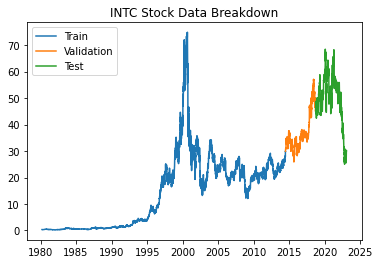

In [70]:
# Splitting the date into 80% train, 10% validation and 10% testing partitions
# Training data will train model, validation will help train the model
# Testing will help evaluate the performance of the model
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])
plt.title('INTC Stock Data Breakdown')

In [71]:
# Creating and training the model. Building a sequential model, optimized with Adam and built up with layers
# layers.Input(3,1) - 3 days in the past and one feature for univariate forecasting
# layers.LSTM(64) - 64 neurons for the LSTM. Bigger the number the more complicated and heavy duty the model is.
# layers.Dense(32, activation='relu') - w/ stacked layers. Activation is 'relu'
# layer.Dense(1) - Ouput of model. It is linear
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

# Compiling the model. Want to minimize Mean Squared Error.
# optimizer=Adam(learning_rate=0.001) - Setting the optimizer for the model at a learning rate of 0.001
# metrics=['mean_absolute_error'] tells us the average distance we are off by instead of MSE
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])
# Let the model run 100 times. Focused on val_mean_absolute error for performance of the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
270/270 [==============================] - 4s 7ms/step - loss: 67.0720 - mean_absolute_error: 3.1567 - val_loss: 0.7551 - val_mean_absolute_error: 0.7052
Epoch 2/100
270/270 [==============================] - 1s 5ms/step - loss: 0.4703 - mean_absolute_error: 0.3216 - val_loss: 0.5309 - val_mean_absolute_error: 0.5483
Epoch 3/100
270/270 [==============================] - 1s 5ms/step - loss: 0.4241 - mean_absolute_error: 0.3159 - val_loss: 0.4619 - val_mean_absolute_error: 0.4976
Epoch 4/100
270/270 [==============================] - 2s 6ms/step - loss: 0.4495 - mean_absolute_error: 0.3311 - val_loss: 1.3411 - val_mean_absolute_error: 0.7117
Epoch 5/100
270/270 [==============================] - 1s 5ms/step - loss: 0.4289 - mean_absolute_error: 0.3352 - val_loss: 0.5382 - val_mean_absolute_error: 0.5189
Epoch 6/100
270/270 [==============================] - 1s 6ms/step - loss: 0.3974 - mean_absolute_error: 0.3190 - val_loss: 0.4176 - val_mean_absolute_error: 0.4320
Epoch 7/1

270/270 [==============================] - 1s 2ms/step


Text(0.5, 1.0, 'Training Closing Price Predictions vs Observations for INTC Stock')

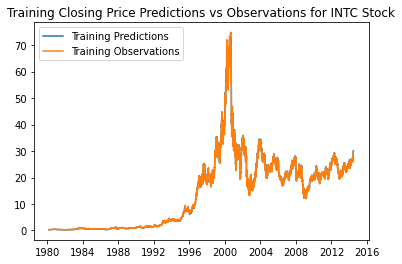

In [72]:
# Prediction on the training set plotted.
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])
plt.title('Training Closing Price Predictions vs Observations for INTC Stock')

34/34 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Validation Closing Price Predictions vs Observations for INTC Stock')

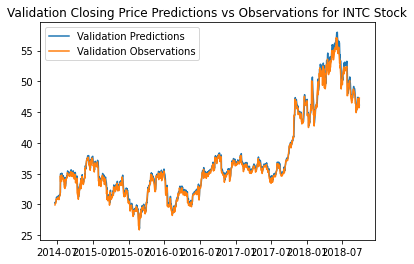

In [73]:
# Prediction on the validation set plotted.
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.title('Validation Closing Price Predictions vs Observations for INTC Stock')

34/34 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Testing Closing Price Predictions vs Observations for INTC Stock')

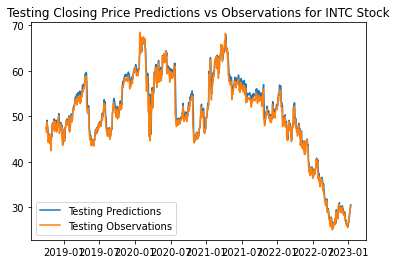

In [74]:
# Prediction on the test set plotted.

test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])
plt.title('Testing Closing Price Predictions vs Observations for INTC Stock')

Text(0.5, 1.0, 'All Closing Price Predictions vs Observations for INTC Stock')

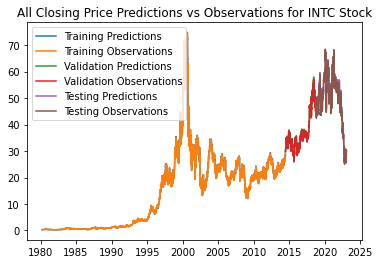

In [75]:
# All three predictions on one graph
# Follows observations closely 
# Should be noted that for other stocks, LSTM models are bad at extrapolating data outside training range
# Might be more appropriate to use more recent training data
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])
plt.title('All Closing Price Predictions vs Observations for INTC Stock')